In [23]:
import numpy as np
import matplotlib.pyplot as plt
from prose import FitsManager, Sequence, blocks, FITSImage, Fluxes

In [27]:
fits_folder = "./data/images/20250410"
fm = FitsManager(fits_folder, depth=3)
fm

Parsing FITS:   0%|          | 0/180 [00:00<?, ?it/s]

,date,telescope,filter,type,target,width,height,files
id,,,,,,,,
1,2025-04-10,HPP-ETHZ,G,bias,,2916,2187,6
13,2025-04-10,HPP-ETHZ,G,dark,,2916,2187,28
3,2025-04-10,HPP-ETHZ,G,flat,,2916,2187,36
2,2025-04-10,HPP-ETHZ,G,light,TrES-2b,2916,2187,110


In [28]:
files = fm.observation_files(2)

,date,telescope,filter,type,target,width,height,exposure,files
id,,,,,,,,,
2,2025-04-10,HPP-ETHZ,G,light,TrES-2b,2916,2187,120.000000,110
13,2025-04-10,HPP-ETHZ,G,dark,,2916,2187,17.000000,5
5,2025-04-10,HPP-ETHZ,G,dark,,2916,2187,34.000000,4
12,2025-04-10,HPP-ETHZ,G,dark,,2916,2187,51.000000,5
4,2025-04-10,HPP-ETHZ,G,dark,,2916,2187,68.000000,5
10,2025-04-10,HPP-ETHZ,G,dark,,2916,2187,85.000000,5
8,2025-04-10,HPP-ETHZ,G,dark,,2916,2187,102.000000,4
1,2025-04-10,HPP-ETHZ,G,bias,,2916,2187,0.000000,6
3,2025-04-10,HPP-ETHZ,G,flat,,2916,2187,1.780586,11


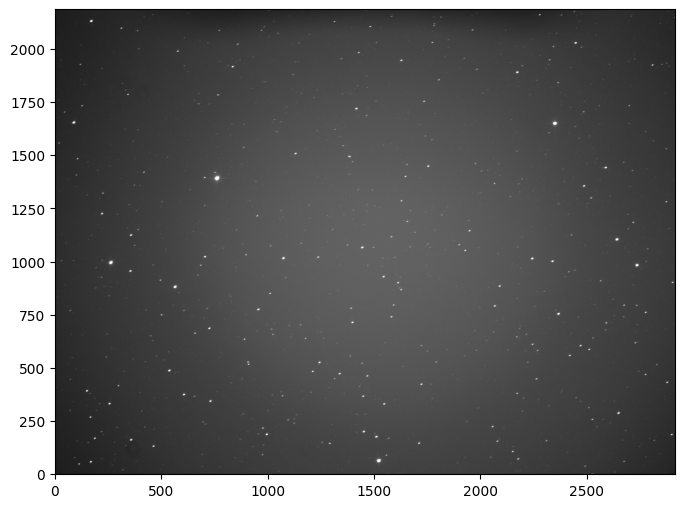

In [29]:
# reference is middle image
ref = FITSImage(files["images"][len(files["images"]) // 2])
ref.show()

    solution_id             designation          ... epoch_photometry_url
                                                 ...                     
------------------- ---------------------------- ... --------------------
1635721458409799680 Gaia DR2 2131278809411630976 ...                     
1635721458409799680 Gaia DR2 2131322549358500480 ...                     
1635721458409799680 Gaia DR2 2132034311337643904 ...                     
1635721458409799680 Gaia DR2 2131298291383139712 ...                     
1635721458409799680 Gaia DR2 2131327119203798016 ...                     
1635721458409799680 Gaia DR2 2132043725906164224 ...                     
1635721458409799680 Gaia DR2 2132072416287737856 ...                     
1635721458409799680 Gaia DR2 2131246197720018560 ...                     
1635721458409799680 Gaia DR2 2131285269042242816 ...                     
1635721458409799680 Gaia DR2 2131281077154105856 ...                     
                ...                   

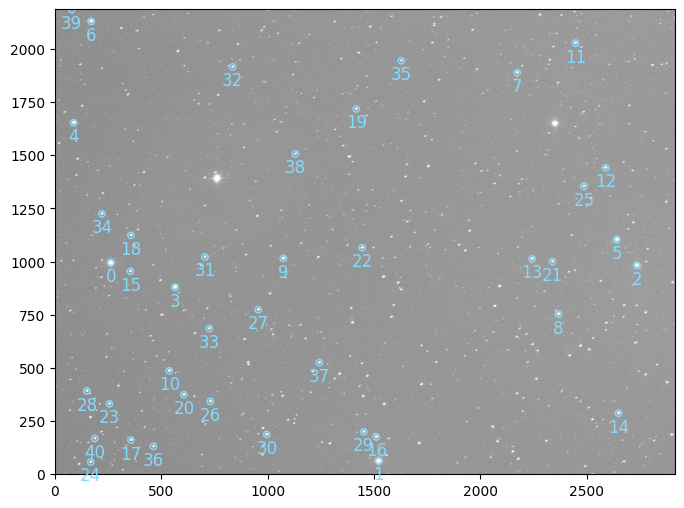

In [30]:
calibration = Sequence(
    [
        blocks.Calibration(
            darks=files["darks"], bias=files["bias"], flats=files["flats"]
        ),
        blocks.Trim(),
        blocks.PointSourceDetection(n=41, saturation=60000),  # stars detection
        blocks.catalogs.PlateSolve(debug=False),
        blocks.catalogs.GaiaCatalog(),
        blocks.Cutouts(41),  # stars cutouts
        blocks.MedianEPSF(),  # building EPSF
        blocks.psf.Gaussian2D(),  # modeling EPSF
    ]
)

calibration.run(ref, show_progress=False)
ref.show()

In [14]:
calibration

╒═════════╤════════╤══════════════════════╤════════════════╕
│   index │ name   │ type                 │ processing     │
╞═════════╪════════╪══════════════════════╪════════════════╡
│       0 │        │ Calibration          │ 0.122 s (0%)   │
├─────────┼────────┼──────────────────────┼────────────────┤
│       1 │        │ Trim                 │ 0.279 s (1%)   │
├─────────┼────────┼──────────────────────┼────────────────┤
│       2 │        │ PointSourceDetection │ 0.234 s (1%)   │
├─────────┼────────┼──────────────────────┼────────────────┤
│       3 │        │ PlateSolve           │ 28.307 s (68%) │
├─────────┼────────┼──────────────────────┼────────────────┤
│       4 │        │ GaiaCatalog          │ 9.375 s (23%)  │
├─────────┼────────┼──────────────────────┼────────────────┤
│       5 │        │ Cutouts              │ 2.824 s (7%)   │
├─────────┼────────┼──────────────────────┼────────────────┤
│       6 │        │ MedianEPSF           │ 0.007 s (0%)   │
├─────────┼────────┼────

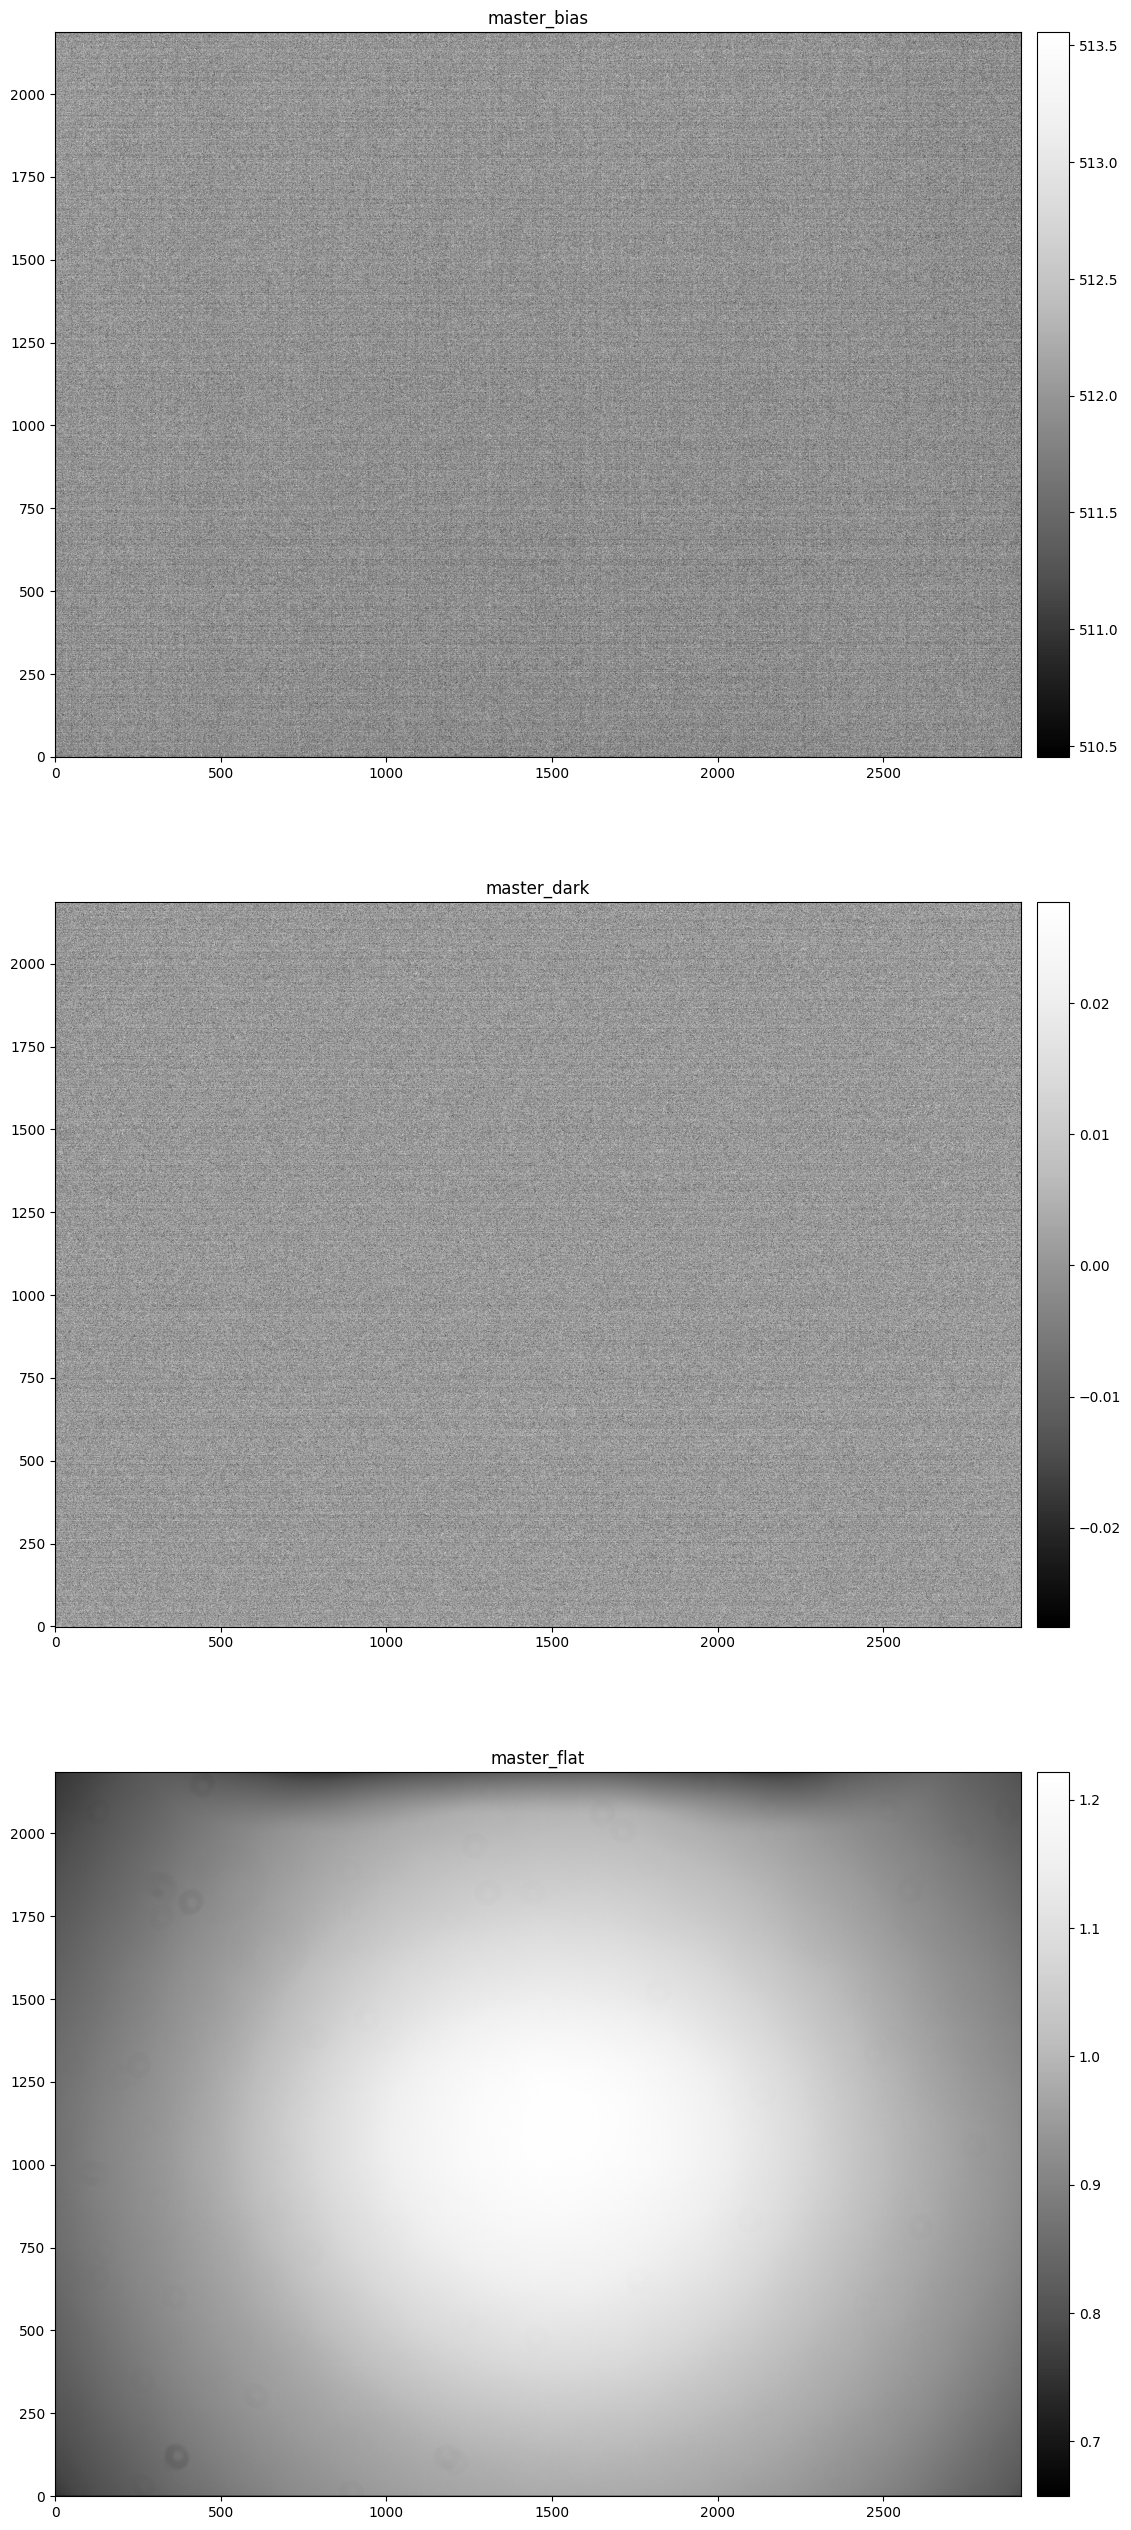

In [68]:
from astropy.visualization import ZScaleInterval

masters = calibration[0]

fig, ax = plt.subplots(3,1, figsize=(16,32))

for i in range(3):
    if i == 0:
        data = masters.master_bias
        title = 'master_bias'
        contrast = 0.5
    elif i == 1:
        data = masters.master_dark
        title = 'master_dark'
        contrast = 0.5
    elif i == 2:
        data = masters.master_flat
        title = 'master_flat'
        contrast = 0.5

    interval = ZScaleInterval(contrast=contrast)
    vmin, vmax = interval.get_limits(data)
    
    # vmin = np.nanmedian(data)
    # vmax = vmax = vmin * (1 + contrast) / (1 - contrast)
    im = ax[i].imshow(
        data, cmap="Greys_r", origin="lower", vmin=vmin, vmax=vmax,
    )
    ax[i].set_title(title)
    cax = fig.add_axes([ax[i].get_position().x1+0.01,ax[i].get_position().y0,0.02,ax[i].get_position().height])
    fig.colorbar(im, cax=cax)

In [7]:
import numpy as np


def find_nearest_idx(array, value):
    """
    Finds nearest index in array from value provided

    Params:


    Returns:
        index

    Raises:
        None

    """

    array = np.asarray(array)
    if array.ndim == 1:
        idx = (np.abs(array - value)).argmin()
    else:
        idx = np.sum((np.abs(array - value)), axis=-1).argmin()
    return int(idx)

In [8]:
gaias = ref.catalogs["gaia"]["id"]
gaia_id = "Gaia DR2 2131314401800665344"
match_id = np.where(gaias == gaia_id)
match_coords = ref.catalogs["gaia"][["x", "y"]].values[match_id]
target_idx = find_nearest_idx(ref.sources.coords, match_coords)

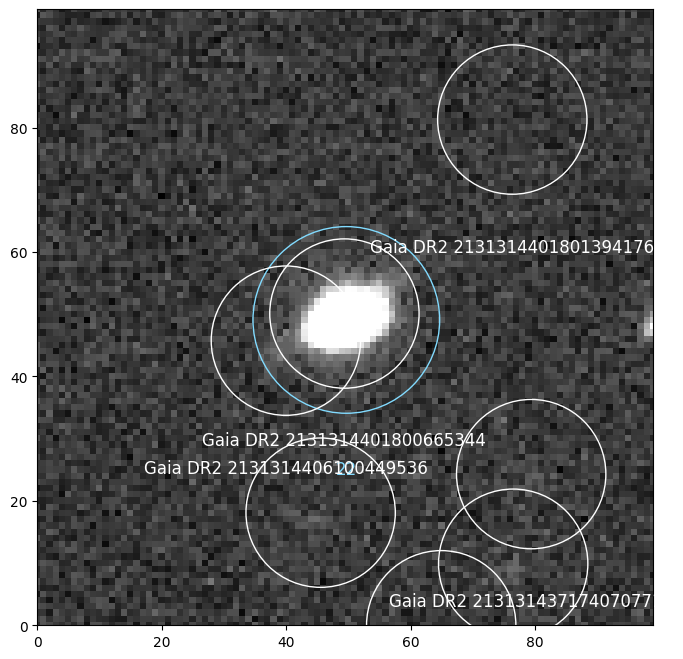

In [9]:
cutout = ref.cutout(target_idx, 100, reset_index=False)
cutout.show()
cutout.plot_catalog("gaia", label=True, color="w")

In [10]:
photometry = Sequence(
    [
        calibration[0],  # calibration block (same as above)
        blocks.Trim(),
        blocks.PointSourceDetection(n=20, minor_length=8),  # fewer stars detection
        blocks.Cutouts(41),  # stars cutouts
        blocks.MedianEPSF(),  # building EPSF
        blocks.Gaussian2D(ref),  # modeling EPSF with initial guess
        blocks.ComputeTransformTwirl(ref),  # compute alignment
        blocks.AlignReferenceSources(ref),  # alignment
        blocks.CentroidQuadratic(),  # centroiding
        blocks.AperturePhotometry(),  # aperture photometry
        blocks.AnnulusBackground(),  # annulus background
        blocks.GetFluxes(
            "fwhm",
            airmass=lambda im: im.header["AIRMASS"],
            dx=lambda im: im.transform.translation[0],
            dy=lambda im: im.transform.translation[1],
        ),
    ]
)

In [11]:
photometry.run(files["images"])

  0%|          | 0/110 [00:00<?, ?images/s]

In [12]:
photometry

╒═════════╤════════╤═══════════════════════╤════════════════╕
│   index │ name   │ type                  │ processing     │
╞═════════╪════════╪═══════════════════════╪════════════════╡
│       0 │        │ Calibration           │ 3.517 s (4%)   │
├─────────┼────────┼───────────────────────┼────────────────┤
│       1 │        │ Trim                  │ 0.468 s (0%)   │
├─────────┼────────┼───────────────────────┼────────────────┤
│       2 │        │ PointSourceDetection  │ 45.607 s (48%) │
├─────────┼────────┼───────────────────────┼────────────────┤
│       3 │        │ Cutouts               │ 3.168 s (3%)   │
├─────────┼────────┼───────────────────────┼────────────────┤
│       4 │        │ MedianEPSF            │ 0.212 s (0%)   │
├─────────┼────────┼───────────────────────┼────────────────┤
│       5 │        │ Gaussian2D            │ 12.331 s (13%) │
├─────────┼────────┼───────────────────────┼────────────────┤
│       6 │        │ ComputeTransformTwirl │ 12.219 s (13%) │
├───────